In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [2]:
PRE_EPOCHS = config["pretrain_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [3]:
BATCH_SIZE = 5
dataset = data.LensingDataset(PATH_TO_IMAGES,['no_sub'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [4]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)
bc_loss = torch.nn.MSELoss()

i_preopt = torch.optim.Adam(params=i_model.parameters(),lr=LR)
total_params = sum(p.numel() for p in i_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 899843


In [5]:
def give_random_image(dataset, model1, model2, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = torch.tensor(LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE))
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    t3 = phy_loss.get_source(t1)
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(t3.numpy()[0][0]*255)
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, image3)

def show_random_image(image_tuple):
    image0, image1, image2, image3 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3]
    plot, axes = plt.subplots(1,4)
    plot.set_size_inches(24,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source")
    axes[3].set_title("Source_reg")

Pre-training epoch 1: 100%|██████████| 800/800 [00:33<00:00, 23.55it/s]


Pre-training at epoch 1/100: 0.12463963196612894 at LR=0.0001


Validation epoch 0: 100%|██████████| 200/200 [00:03<00:00, 62.91it/s]


Validation at epoch 1/50: 0.1159793122857809 at LR=0.0001


Pre-training epoch 2: 100%|██████████| 800/800 [00:33<00:00, 23.67it/s]


Pre-training at epoch 2/100: 0.10962256415747106 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:03<00:00, 62.80it/s]


Validation at epoch 2/50: 0.10021144792437553 at LR=0.0001


Pre-training epoch 3: 100%|██████████| 800/800 [00:33<00:00, 23.65it/s]


Pre-training at epoch 3/100: 0.096699357656762 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:03<00:00, 62.64it/s]


Validation at epoch 3/50: 0.08868847843259572 at LR=0.0001


Pre-training epoch 4: 100%|██████████| 800/800 [00:33<00:00, 23.63it/s]


Pre-training at epoch 4/100: 0.08516230654437094 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:03<00:00, 62.55it/s]


Validation at epoch 4/50: 0.07665970772504807 at LR=0.0001


Pre-training epoch 5: 100%|██████████| 800/800 [00:33<00:00, 23.59it/s]


Pre-training at epoch 5/100: 0.0748194353794679 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:03<00:00, 62.46it/s]


Validation at epoch 5/50: 0.07212704494595527 at LR=0.0001


Pre-training epoch 6: 100%|██████████| 800/800 [00:33<00:00, 23.55it/s]


Pre-training at epoch 6/100: 0.06553605712018908 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:03<00:00, 62.34it/s]


Validation at epoch 6/50: 0.06101740926504135 at LR=0.0001


Pre-training epoch 7: 100%|██████████| 800/800 [00:34<00:00, 23.52it/s]


Pre-training at epoch 7/100: 0.05731222502887249 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:03<00:00, 62.54it/s]


Validation at epoch 7/50: 0.05564972454681993 at LR=0.0001


Pre-training epoch 8: 100%|██████████| 800/800 [00:34<00:00, 23.51it/s]


Pre-training at epoch 8/100: 0.04997646641917527 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:03<00:00, 62.20it/s]


Validation at epoch 8/50: 0.04680529199540615 at LR=0.0001


Pre-training epoch 9: 100%|██████████| 800/800 [00:34<00:00, 23.49it/s]


Pre-training at epoch 9/100: 0.04348117461660877 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:03<00:00, 62.16it/s]


Validation at epoch 9/50: 0.03960907563567161 at LR=0.0001


Pre-training epoch 10: 100%|██████████| 800/800 [00:34<00:00, 23.47it/s]


Pre-training at epoch 10/100: 0.037712125997059046 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:03<00:00, 62.17it/s]


Validation at epoch 10/50: 0.03419152297079563 at LR=0.0001


Pre-training epoch 11: 100%|██████████| 800/800 [00:34<00:00, 23.46it/s]


Pre-training at epoch 11/100: 0.03262283789226785 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:03<00:00, 62.32it/s]


Validation at epoch 11/50: 0.031001793509349226 at LR=0.0001


Pre-training epoch 12: 100%|██████████| 800/800 [00:34<00:00, 23.45it/s]


Pre-training at epoch 12/100: 0.02812933885259554 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:03<00:00, 62.26it/s]


Validation at epoch 12/50: 0.027700622379779816 at LR=0.0001


Pre-training epoch 13: 100%|██████████| 800/800 [00:34<00:00, 23.45it/s]


Pre-training at epoch 13/100: 0.02419338689185679 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:03<00:00, 62.17it/s]


Validation at epoch 13/50: 0.022593801245093345 at LR=0.0001


Pre-training epoch 14: 100%|██████████| 800/800 [00:34<00:00, 23.44it/s]


Pre-training at epoch 14/100: 0.020743224053876474 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:03<00:00, 62.46it/s]


Validation at epoch 14/50: 0.01944065174087882 at LR=0.0001


Pre-training epoch 15: 100%|██████████| 800/800 [00:34<00:00, 23.43it/s]


Pre-training at epoch 15/100: 0.017729308605194092 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:03<00:00, 62.12it/s]


Validation at epoch 15/50: 0.01747036072425544 at LR=0.0001


Pre-training epoch 16: 100%|██████████| 800/800 [00:34<00:00, 23.37it/s]


Pre-training at epoch 16/100: 0.015117566661210731 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:03<00:00, 61.64it/s]


Validation at epoch 16/50: 0.01372214856557548 at LR=0.0001


Pre-training epoch 17: 100%|██████████| 800/800 [00:34<00:00, 23.37it/s]


Pre-training at epoch 17/100: 0.01284766140510328 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:03<00:00, 62.23it/s]


Validation at epoch 17/50: 0.013050667536444962 at LR=0.0001


Pre-training epoch 18: 100%|██████████| 800/800 [00:34<00:00, 23.36it/s]


Pre-training at epoch 18/100: 0.010888922753510997 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:03<00:00, 61.86it/s]


Validation at epoch 18/50: 0.009532566238194705 at LR=0.0001


Pre-training epoch 19: 100%|██████████| 800/800 [00:34<00:00, 23.37it/s]


Pre-training at epoch 19/100: 0.009197441392461769 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:03<00:00, 61.95it/s]


Validation at epoch 19/50: 0.008178611421026289 at LR=0.0001


Pre-training epoch 20: 100%|██████████| 800/800 [00:34<00:00, 23.37it/s]


Pre-training at epoch 20/100: 0.0077588289635605176 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:03<00:00, 62.05it/s]


Validation at epoch 20/50: 0.0064594352315180004 at LR=0.0001


Pre-training epoch 21: 100%|██████████| 800/800 [00:34<00:00, 23.35it/s]


Pre-training at epoch 21/100: 0.006502503028605134 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:03<00:00, 61.96it/s]


Validation at epoch 21/50: 0.005490524498745799 at LR=0.0001


Pre-training epoch 22: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Pre-training at epoch 22/100: 0.005442748866626062 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:03<00:00, 62.11it/s]


Validation at epoch 22/50: 0.00504919046536088 at LR=0.0001


Pre-training epoch 23: 100%|██████████| 800/800 [00:34<00:00, 23.36it/s]


Pre-training at epoch 23/100: 0.004541665876458865 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:03<00:00, 62.14it/s]


Validation at epoch 23/50: 0.003827074742875993 at LR=0.0001


Pre-training epoch 24: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Pre-training at epoch 24/100: 0.00378338410082506 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:03<00:00, 62.07it/s]


Validation at epoch 24/50: 0.0030254083382897077 at LR=0.0001


Pre-training epoch 25: 100%|██████████| 800/800 [00:34<00:00, 23.35it/s]


Pre-training at epoch 25/100: 0.003131459333526436 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:03<00:00, 61.86it/s]


Validation at epoch 25/50: 0.002794915520353243 at LR=0.0001


Pre-training epoch 26: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 26/100: 0.00259353853558423 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:03<00:00, 62.08it/s]


Validation at epoch 26/50: 0.0023120259784627705 at LR=0.0001


Pre-training epoch 27: 100%|██████████| 800/800 [00:34<00:00, 23.35it/s]


Pre-training at epoch 27/100: 0.002141301033188938 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:03<00:00, 61.90it/s]


Validation at epoch 27/50: 0.0016222114977426827 at LR=0.0001


Pre-training epoch 28: 100%|██████████| 800/800 [00:34<00:00, 23.35it/s]


Pre-training at epoch 28/100: 0.0017660150012670784 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:03<00:00, 62.16it/s]


Validation at epoch 28/50: 0.0014285882969852536 at LR=0.0001


Pre-training epoch 29: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Pre-training at epoch 29/100: 0.0014473871028894791 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:03<00:00, 62.18it/s]


Validation at epoch 29/50: 0.0011141734156990424 at LR=0.0001


Pre-training epoch 30: 100%|██████████| 800/800 [00:34<00:00, 23.35it/s]


Pre-training at epoch 30/100: 0.0011914598326620762 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:03<00:00, 61.92it/s]


Validation at epoch 30/50: 0.000932700488192495 at LR=0.0001


Pre-training epoch 31: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Pre-training at epoch 31/100: 0.0009754865992726991 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:03<00:00, 61.75it/s]


Validation at epoch 31/50: 0.0006958972141728737 at LR=0.0001


Pre-training epoch 32: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Pre-training at epoch 32/100: 0.000843501445815491 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:03<00:00, 62.03it/s]


Validation at epoch 32/50: 0.0006607472820905968 at LR=0.0001


Pre-training epoch 33: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 33/100: 0.0006602300060694688 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:03<00:00, 61.71it/s]


Validation at epoch 33/50: 0.0005360696191200986 at LR=0.0001


Pre-training epoch 34: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 34/100: 0.0005299905369247427 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:03<00:00, 61.59it/s]


Validation at epoch 34/50: 0.0004085075884358957 at LR=0.0001


Pre-training epoch 35: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 35/100: 0.0004661445770216233 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:03<00:00, 62.17it/s]


Validation at epoch 35/50: 0.00041152622405206786 at LR=0.0001


Pre-training epoch 36: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 36/100: 0.00040815492330693816 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:03<00:00, 61.94it/s]


Validation at epoch 36/50: 0.00031553076856653204 at LR=0.0001


Pre-training epoch 37: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 37/100: 0.00034145895991969153 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:03<00:00, 62.05it/s]


Validation at epoch 37/50: 0.0002309021422843216 at LR=0.0001


Pre-training epoch 38: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 38/100: 0.0002526969108566846 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:03<00:00, 62.07it/s]


Validation at epoch 38/50: 0.00024569945308030585 at LR=0.0001


Pre-training epoch 39: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 39/100: 0.00021706069687297714 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:03<00:00, 61.81it/s]


Validation at epoch 39/50: 0.00016051921069447416 at LR=0.0001


Pre-training epoch 40: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 40/100: 0.00018605423562348733 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:03<00:00, 62.00it/s]


Validation at epoch 40/50: 0.00013205235332861776 at LR=0.0001


Pre-training epoch 41: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 41/100: 0.000178180502689429 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:03<00:00, 61.94it/s]


Validation at epoch 41/50: 0.0001232367174816318 at LR=0.0001


Pre-training epoch 42: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 42/100: 0.0001538774924028985 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:03<00:00, 61.66it/s]


Validation at epoch 42/50: 0.00016557933151489123 at LR=0.0001


Pre-training epoch 43: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 43/100: 0.00016599679971932347 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:03<00:00, 61.50it/s]


Validation at epoch 43/50: 0.00014451883653237018 at LR=0.0001


Pre-training epoch 44: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 44/100: 0.00012222390878378065 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:03<00:00, 62.19it/s]


Validation at epoch 44/50: 6.689079104035046e-05 at LR=0.0001


Pre-training epoch 45: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 45/100: 9.71196469458846e-05 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:03<00:00, 62.08it/s]


Validation at epoch 45/50: 0.00011502271314384416 at LR=0.0001


Pre-training epoch 46: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 46/100: 9.49917135267242e-05 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:03<00:00, 61.62it/s]


Validation at epoch 46/50: 5.905771737161558e-05 at LR=0.0001


Pre-training epoch 47: 100%|██████████| 800/800 [00:34<00:00, 23.28it/s]


Pre-training at epoch 47/100: 9.21616537243608e-05 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:03<00:00, 61.68it/s]


Validation at epoch 47/50: 5.916735615755897e-05 at LR=0.0001


Pre-training epoch 48: 100%|██████████| 800/800 [00:34<00:00, 23.24it/s]


Pre-training at epoch 48/100: 7.727762474360133e-05 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:03<00:00, 61.59it/s]


Validation at epoch 48/50: 5.93180507166835e-05 at LR=0.0001


Pre-training epoch 49: 100%|██████████| 800/800 [00:34<00:00, 23.28it/s]


Pre-training at epoch 49/100: 7.030102075532341e-05 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:03<00:00, 61.95it/s]


Validation at epoch 49/50: 3.983629912909237e-05 at LR=0.0001


Pre-training epoch 50: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 50/100: 6.781274038985429e-05 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:03<00:00, 61.85it/s]


Validation at epoch 50/50: 6.062122054572683e-05 at LR=0.0001


Pre-training epoch 51: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 51/100: 6.727255382429575e-05 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:03<00:00, 62.09it/s]


Validation at epoch 51/50: 4.110846397452406e-05 at LR=0.0001


Pre-training epoch 52: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 52/100: 6.638273538783323e-05 at LR=0.0001


Validation epoch 51: 100%|██████████| 200/200 [00:03<00:00, 61.98it/s]


Validation at epoch 52/50: 3.758065355214058e-05 at LR=0.0001


Pre-training epoch 53: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 53/100: 5.729732045779201e-05 at LR=0.0001


Validation epoch 52: 100%|██████████| 200/200 [00:03<00:00, 61.98it/s]


Validation at epoch 53/50: 4.047996151712141e-05 at LR=0.0001


Pre-training epoch 54: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 54/100: 5.7187408380059424e-05 at LR=0.0001


Validation epoch 53: 100%|██████████| 200/200 [00:03<00:00, 61.63it/s]


Validation at epoch 54/50: 0.0003892142110998975 at LR=0.0001


Pre-training epoch 55: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 55/100: 6.641154652243131e-05 at LR=0.0001


Validation epoch 54: 100%|██████████| 200/200 [00:03<00:00, 61.92it/s]


Validation at epoch 55/50: 3.861072776999208e-05 at LR=0.0001


Pre-training epoch 56: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 56/100: 5.16336041721388e-05 at LR=0.0001


Validation epoch 55: 100%|██████████| 200/200 [00:03<00:00, 62.12it/s]


Validation at epoch 56/50: 3.2353512788176884e-05 at LR=0.0001


Pre-training epoch 57: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 57/100: 5.8219396610184046e-05 at LR=0.0001


Validation epoch 56: 100%|██████████| 200/200 [00:03<00:00, 61.93it/s]


Validation at epoch 57/50: 2.746029168520181e-05 at LR=0.0001


Pre-training epoch 58: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 58/100: 4.585273220300223e-05 at LR=0.0001


Validation epoch 57: 100%|██████████| 200/200 [00:03<00:00, 62.07it/s]


Validation at epoch 58/50: 1.796211045984819e-05 at LR=0.0001


Pre-training epoch 59: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 59/100: 4.387998081142541e-05 at LR=0.0001


Validation epoch 58: 100%|██████████| 200/200 [00:03<00:00, 61.92it/s]


Validation at epoch 59/50: 2.9649499092556654e-05 at LR=0.0001


Pre-training epoch 60: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 60/100: 5.402748900792176e-05 at LR=0.0001


Validation epoch 59: 100%|██████████| 200/200 [00:03<00:00, 61.83it/s]


Validation at epoch 60/50: 2.832640854649071e-05 at LR=0.0001


Pre-training epoch 61: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Pre-training at epoch 61/100: 4.740156251500593e-05 at LR=0.0001


Validation epoch 60: 100%|██████████| 200/200 [00:03<00:00, 62.18it/s]


Validation at epoch 61/50: 2.151222252905427e-05 at LR=0.0001


Pre-training epoch 62: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 62/100: 6.154259030154208e-05 at LR=0.0001


Validation epoch 61: 100%|██████████| 200/200 [00:03<00:00, 62.02it/s]


Validation at epoch 62/50: 5.308048966981005e-05 at LR=0.0001


Pre-training epoch 63: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 63/100: 4.582542711432325e-05 at LR=0.0001


Validation epoch 62: 100%|██████████| 200/200 [00:03<00:00, 61.95it/s]


Validation at epoch 63/50: 4.424507471412653e-05 at LR=0.0001


Pre-training epoch 64: 100%|██████████| 800/800 [00:34<00:00, 23.33it/s]


Pre-training at epoch 64/100: 3.989214697071475e-05 at LR=0.0001


Validation epoch 63: 100%|██████████| 200/200 [00:03<00:00, 61.81it/s]


Validation at epoch 64/50: 2.635702913721616e-05 at LR=0.0001


Pre-training epoch 65: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 65/100: 4.111873345891581e-05 at LR=0.0001


Validation epoch 64: 100%|██████████| 200/200 [00:03<00:00, 61.60it/s]


Validation at epoch 65/50: 1.9867190421791746e-05 at LR=0.0001


Pre-training epoch 66: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 66/100: 4.173068025693283e-05 at LR=0.0001


Validation epoch 65: 100%|██████████| 200/200 [00:03<00:00, 61.63it/s]


Validation at epoch 66/50: 2.0625167326215888e-05 at LR=0.0001


Pre-training epoch 67: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 67/100: 3.8765405279264086e-05 at LR=0.0001


Validation epoch 66: 100%|██████████| 200/200 [00:03<00:00, 61.76it/s]


Validation at epoch 67/50: 0.0001564422619776451 at LR=0.0001


Pre-training epoch 68: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 68/100: 4.11724098285049e-05 at LR=0.0001


Validation epoch 67: 100%|██████████| 200/200 [00:03<00:00, 61.93it/s]


Validation at epoch 68/50: 1.6232940652116667e-05 at LR=0.0001


Pre-training epoch 69: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 69/100: 3.5990361984659105e-05 at LR=0.0001


Validation epoch 68: 100%|██████████| 200/200 [00:03<00:00, 61.72it/s]


Validation at epoch 69/50: 2.8897071761093685e-05 at LR=0.0001


Pre-training epoch 70: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 70/100: 3.473137184982988e-05 at LR=0.0001


Validation epoch 69: 100%|██████████| 200/200 [00:03<00:00, 61.68it/s]


Validation at epoch 70/50: 1.4169860583024274e-05 at LR=0.0001


Pre-training epoch 71: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 71/100: 3.628255139688008e-05 at LR=0.0001


Validation epoch 70: 100%|██████████| 200/200 [00:03<00:00, 61.90it/s]


Validation at epoch 71/50: 1.1404438369027048e-05 at LR=0.0001


Pre-training epoch 72: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 72/100: 3.2608854226054974e-05 at LR=0.0001


Validation epoch 71: 100%|██████████| 200/200 [00:03<00:00, 61.73it/s]


Validation at epoch 72/50: 1.726182848415192e-05 at LR=0.0001


Pre-training epoch 73: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 73/100: 3.7749427540347825e-05 at LR=0.0001


Validation epoch 72: 100%|██████████| 200/200 [00:03<00:00, 61.79it/s]


Validation at epoch 73/50: 1.3770465970992518e-05 at LR=0.0001


Pre-training epoch 74: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 74/100: 3.189809711102498e-05 at LR=0.0001


Validation epoch 73: 100%|██████████| 200/200 [00:03<00:00, 61.84it/s]


Validation at epoch 74/50: 1.3422533916127577e-05 at LR=0.0001


Pre-training epoch 75: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 75/100: 3.2809955724815156e-05 at LR=0.0001


Validation epoch 74: 100%|██████████| 200/200 [00:03<00:00, 61.56it/s]


Validation at epoch 75/50: 1.6049201603891562e-05 at LR=0.0001


Pre-training epoch 76: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 76/100: 4.443395329019495e-05 at LR=0.0001


Validation epoch 75: 100%|██████████| 200/200 [00:03<00:00, 61.70it/s]


Validation at epoch 76/50: 1.7800709242692393e-05 at LR=0.0001


Pre-training epoch 77: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 77/100: 2.954933880232602e-05 at LR=0.0001


Validation epoch 76: 100%|██████████| 200/200 [00:03<00:00, 61.71it/s]


Validation at epoch 77/50: 1.715204129141057e-05 at LR=0.0001


Pre-training epoch 78: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 78/100: 2.959060669468272e-05 at LR=0.0001


Validation epoch 77: 100%|██████████| 200/200 [00:03<00:00, 61.70it/s]


Validation at epoch 78/50: 2.5609525573599966e-05 at LR=0.0001


Pre-training epoch 79: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 79/100: 2.7093993645621593e-05 at LR=0.0001


Validation epoch 78: 100%|██████████| 200/200 [00:03<00:00, 61.96it/s]


Validation at epoch 79/50: 1.1068936246374505e-05 at LR=0.0001


Pre-training epoch 80: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 80/100: 3.79087471026196e-05 at LR=0.0001


Validation epoch 79: 100%|██████████| 200/200 [00:03<00:00, 61.94it/s]


Validation at epoch 80/50: 1.5155927085288568e-05 at LR=0.0001


Pre-training epoch 81: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 81/100: 2.8514166451714118e-05 at LR=0.0001


Validation epoch 80: 100%|██████████| 200/200 [00:03<00:00, 61.56it/s]


Validation at epoch 81/50: 4.5668800121347884e-05 at LR=0.0001


Pre-training epoch 82: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 82/100: 2.8730680521675823e-05 at LR=0.0001


Validation epoch 81: 100%|██████████| 200/200 [00:03<00:00, 61.88it/s]


Validation at epoch 82/50: 8.970858102657075e-06 at LR=0.0001


Pre-training epoch 83: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 83/100: 2.615163724499325e-05 at LR=0.0001


Validation epoch 82: 100%|██████████| 200/200 [00:03<00:00, 61.89it/s]


Validation at epoch 83/50: 2.0086074528080644e-05 at LR=0.0001


Pre-training epoch 84: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 84/100: 2.6312859873200978e-05 at LR=0.0001


Validation epoch 83: 100%|██████████| 200/200 [00:03<00:00, 61.93it/s]


Validation at epoch 84/50: 1.400433959588554e-05 at LR=0.0001


Pre-training epoch 85: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 85/100: 2.463640308747017e-05 at LR=0.0001


Validation epoch 84: 100%|██████████| 200/200 [00:03<00:00, 61.91it/s]


Validation at epoch 85/50: 1.832768470649171e-05 at LR=0.0001


Pre-training epoch 86: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 86/100: 4.803715241791906e-05 at LR=0.0001


Validation epoch 85: 100%|██████████| 200/200 [00:03<00:00, 61.80it/s]


Validation at epoch 86/50: 0.00104661737306742 at LR=0.0001


Pre-training epoch 87: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 87/100: 4.299601384673224e-05 at LR=0.0001


Validation epoch 86: 100%|██████████| 200/200 [00:03<00:00, 62.04it/s]


Validation at epoch 87/50: 1.831123171541549e-05 at LR=0.0001


Pre-training epoch 88: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 88/100: 3.092557436616516e-05 at LR=0.0001


Validation epoch 87: 100%|██████████| 200/200 [00:03<00:00, 61.22it/s]


Validation at epoch 88/50: 1.3524191313081247e-05 at LR=0.0001


Pre-training epoch 89: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 89/100: 2.5690353503478036e-05 at LR=0.0001


Validation epoch 88: 100%|██████████| 200/200 [00:03<00:00, 61.74it/s]


Validation at epoch 89/50: 3.974316391577304e-05 at LR=0.0001


Pre-training epoch 90: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 90/100: 2.7208914166862995e-05 at LR=0.0001


Validation epoch 89: 100%|██████████| 200/200 [00:03<00:00, 61.91it/s]


Validation at epoch 90/50: 3.000879381033883e-05 at LR=0.0001


Pre-training epoch 91: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 91/100: 2.0237519258898828e-05 at LR=0.0001


Validation epoch 90: 100%|██████████| 200/200 [00:03<00:00, 61.82it/s]


Validation at epoch 91/50: 8.626593892131496e-06 at LR=0.0001


Pre-training epoch 92: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 92/100: 2.406756983759806e-05 at LR=0.0001


Validation epoch 91: 100%|██████████| 200/200 [00:03<00:00, 61.72it/s]


Validation at epoch 92/50: 5.615201325781527e-05 at LR=0.0001


Pre-training epoch 93: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 93/100: 2.9573520483836545e-05 at LR=0.0001


Validation epoch 92: 100%|██████████| 200/200 [00:03<00:00, 61.76it/s]


Validation at epoch 93/50: 1.129982345901226e-05 at LR=0.0001


Pre-training epoch 94: 100%|██████████| 800/800 [00:34<00:00, 23.31it/s]


Pre-training at epoch 94/100: 3.316436242130294e-05 at LR=0.0001


Validation epoch 93: 100%|██████████| 200/200 [00:03<00:00, 61.72it/s]


Validation at epoch 94/50: 1.679853860878211e-05 at LR=0.0001


Pre-training epoch 95: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 95/100: 2.6530251972189944e-05 at LR=0.0001


Validation epoch 94: 100%|██████████| 200/200 [00:03<00:00, 61.58it/s]


Validation at epoch 95/50: 1.2080664910172344e-05 at LR=0.0001


Pre-training epoch 96: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 96/100: 2.385743101967819e-05 at LR=0.0001


Validation epoch 95: 100%|██████████| 200/200 [00:03<00:00, 61.83it/s]


Validation at epoch 96/50: 1.3947562847533845e-05 at LR=0.0001


Pre-training epoch 97: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 97/100: 2.3250073068652456e-05 at LR=0.0001


Validation epoch 96: 100%|██████████| 200/200 [00:03<00:00, 61.91it/s]


Validation at epoch 97/50: 1.4745776297786506e-05 at LR=0.0001


Pre-training epoch 98: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 98/100: 2.7649863880014892e-05 at LR=0.0001


Validation epoch 97: 100%|██████████| 200/200 [00:03<00:00, 61.99it/s]


Validation at epoch 98/50: 1.6263048328255535e-05 at LR=0.0001


Pre-training epoch 99: 100%|██████████| 800/800 [00:34<00:00, 23.29it/s]


Pre-training at epoch 99/100: 2.3595158392595294e-05 at LR=0.0001


Validation epoch 98: 100%|██████████| 200/200 [00:03<00:00, 61.96it/s]


Validation at epoch 99/50: 1.3926296401223225e-05 at LR=0.0001


Pre-training epoch 100: 100%|██████████| 800/800 [00:34<00:00, 23.30it/s]


Pre-training at epoch 100/100: 2.1738594572298098e-05 at LR=0.0001


Validation epoch 99: 100%|██████████| 200/200 [00:03<00:00, 61.60it/s]
/tmp/ipykernel_4307/2354319361.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE))


Validation at epoch 100/50: 8.838037460918713e-06 at LR=0.0001


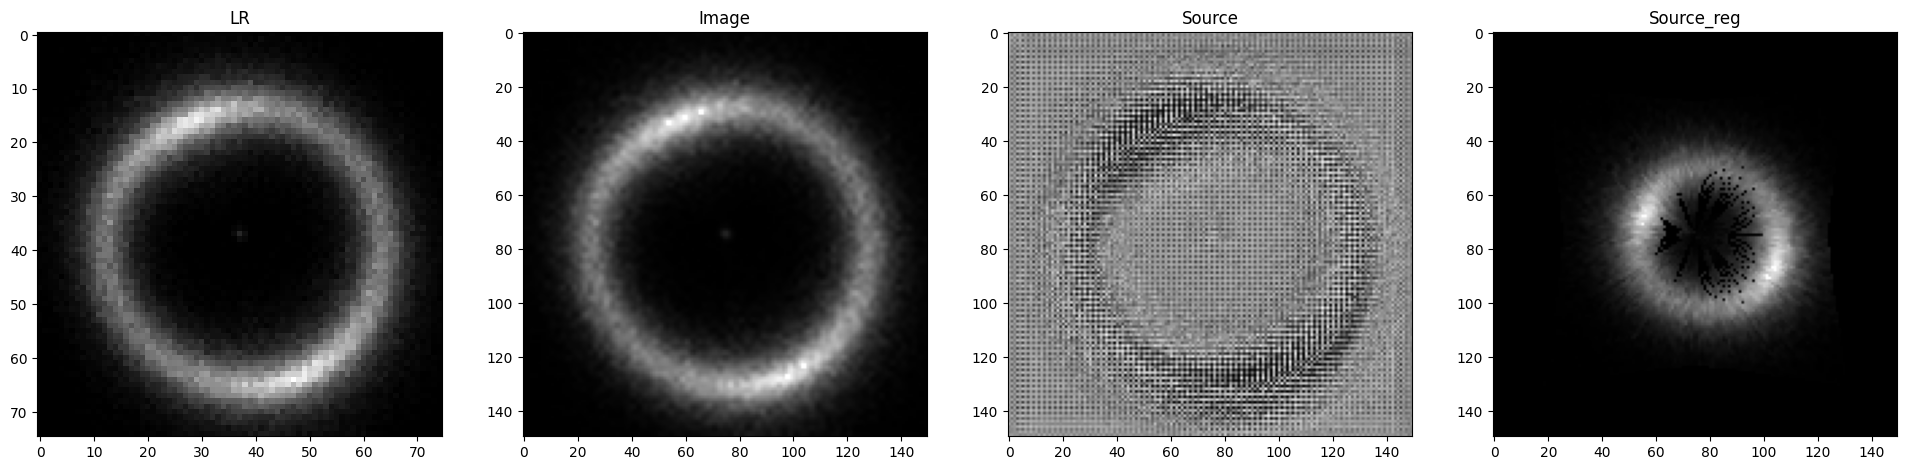

In [6]:
history = {'pre_loss':[],'val_loss':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None

for epoch in range(PRE_EPOCHS):
    losses = []
    i_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Pre-training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        bc_image = torch.nn.functional.interpolate(input=x, scale_factor=MAGNIFICATION,mode='bicubic')
        loss = bc_loss(image, bc_image)
        i_preopt.zero_grad()
        loss.backward()
        i_preopt.step()
        losses.append(float(loss))
    print(f"Pre-training at epoch {epoch+1}/{PRE_EPOCHS}: {np.mean(losses)} at LR={i_preopt.param_groups[0]['lr']}")
    history['pre_loss'].append(losses)
    i_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        bc_image = torch.nn.functional.interpolate(input=x, scale_factor=MAGNIFICATION,mode='bicubic')
        val_loss = bc_loss(image, bc_image)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = i_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{PRE_EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

i_model.load_state_dict(best_weights)
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [7]:
torch.save(i_model.state_dict(),'bicubic.pt')

/tmp/ipykernel_4307/2354319361.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE))


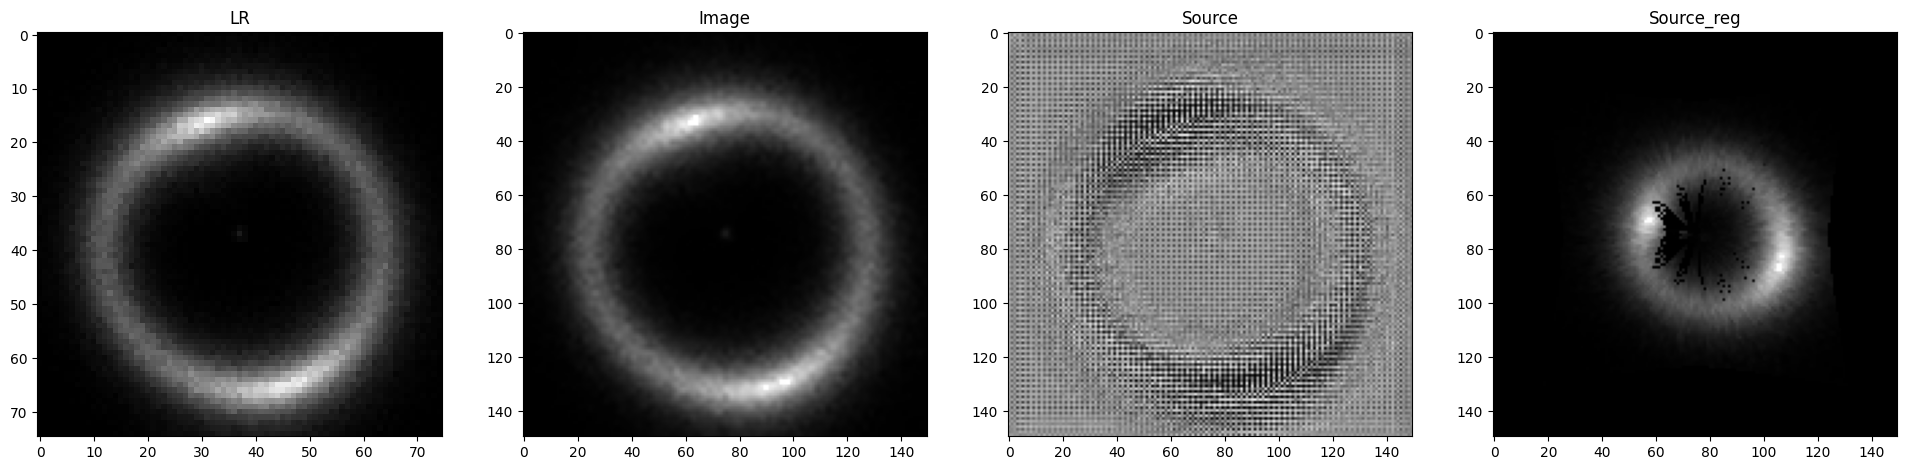

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))